In [1]:
# 必要なパッケージをインポート
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

from statsmodels.graphics.tsaplots import plot_acf


In [2]:
import pymc as pm
import arviz as az
import pytensor.tensor as pt

In [3]:
print(np.__version__)
print(pm.__version__)
print(az.__version__)

1.23.5
5.7.2
0.15.1


## データの準備など

In [5]:
# データ準備
fish_parray = pd.read_csv("data/3-8-1-fish-num-1.csv")
fish_df = pd.DataFrame(fish_parray)

print(fish_df.shape)
display(fish_df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'data/3-8-1-fish-num-1.csv'

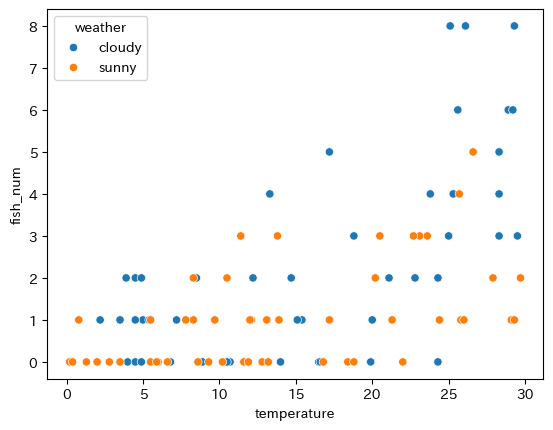

In [ ]:
# データの可視化
fig, ax = plt.subplots()
ax = sns.scatterplot(x = fish_parray["temperature"], y = fish_parray["fish_num"],
                     hue = fish_parray["weather"])

In [ ]:
# データの準備
y = fish_parray["fish_num"].values
X_dum_df = pd.get_dummies(fish_df.drop("fish_num", axis=1), dtype=int, drop_first=True)
col_li = X_dum_df.columns # 説明変数の次元指定用に取得
X = X_dum_df.values

print(y.shape)
print(y[:10])
print(X.shape)
print(X[:10])
print(col_li)

(100,)
[0 2 5 1 3 5 2 3 0 0]
(100, 2)
[[ 5.5  0. ]
 [21.1  0. ]
 [17.2  0. ]
 [ 5.   0. ]
 [28.3  0. ]
 [28.3  0. ]
 [ 3.9  0. ]
 [25.   0. ]
 [14.   0. ]
 [16.5  0. ]]
Index(['temperature', 'weather_sunny'], dtype='object')


## ベイズ推論

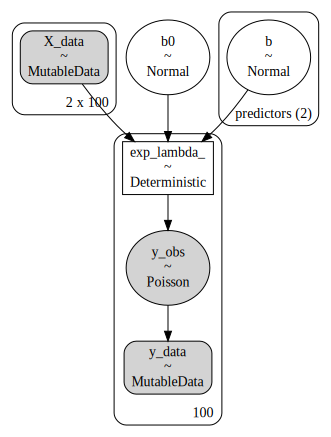

In [ ]:
# 確率モデルの定義
model = pm.Model(coords={"predictors":col_li})

with model:
    # 観測値をConstantDataとして定義
    y_data = pm.Data("y_data", y, mutable=True)
    X_data = pm.Data("X_data", X.T, mutable=True)

    # パラメータを確率変数として定義
    b0 = pm.Normal("b0", mu=0, sigma=10000)
    b = pm.Normal("b", mu=0, sigma=10000, dims="predictors")

    # 目的変数の期待値を確率変数として定義
    exp_lambda_ = pm.Deterministic("exp_lambda_", pt.exp(b @ X_data + b0))

    # 観測値を持つ確率変数として定義
    y_obs = pm.Poisson("y_obs", mu=exp_lambda_, observed=y_data)

g = pm.model_to_graphviz(model)
display(g)

In [ ]:
# パラメータのMCMCサンプリング
with model:
    idata1 = pm.sample(
        chains = 2,
        tune = 1000,
        draws = 1000,
        random_seed = 42
    )

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


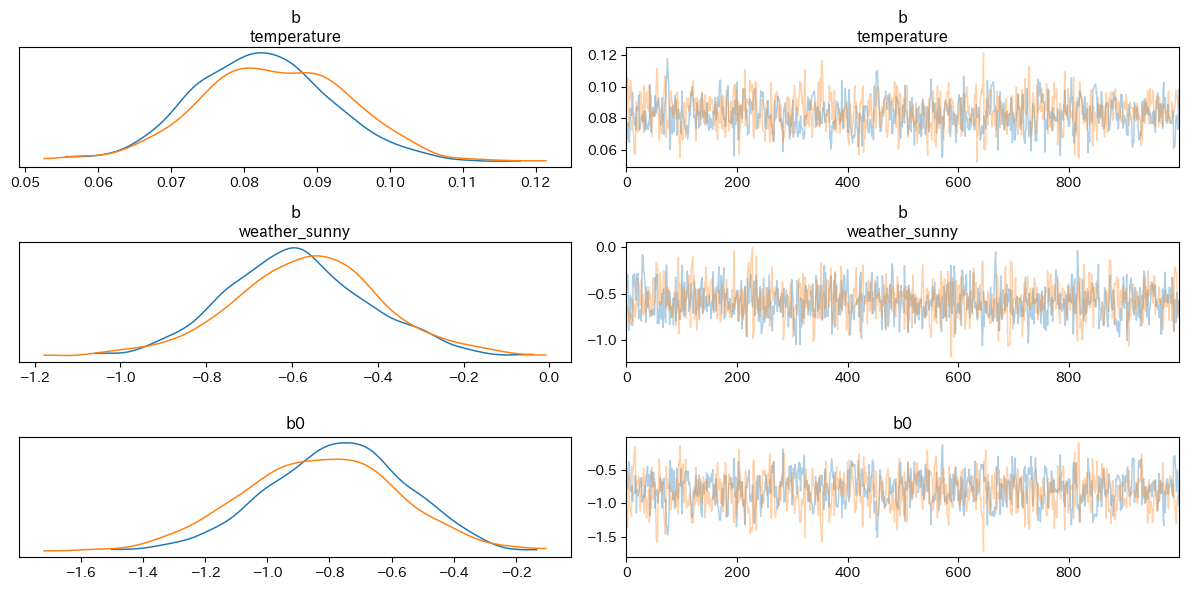

In [ ]:
# 事後分布の可視化
az.plot_trace(idata1, compact=False, var_names=["b", "b0"])
plt.tight_layout();

In [ ]:
# MCMCサンプルの統計量
az.summary(idata1, var_names=["b", "b0"])

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[temperature],0.083,0.010,0.065,0.102,0.000,0.000,714.0,718.0,1.01
b[weather_sunny],-0.577,0.171,-0.897,-0.254,0.006,0.004,958.0,949.0,1.01
b0,-0.805,0.238,-1.221,-0.347,0.009,0.007,647.0,882.0,1.01


## 回帰直線の描画(売上の期待値の分布)